# Berlin Transport Network - Data Verification

This notebook verifies the processed Berlin transport network data to ensure data quality and consistency. It performs the following checks:

1. **Transport Types**: Verifies that all transport types are in the allowed set (autobus, omnibus, tram, u-bahn, s-bahn, ferry/fähre, strassenbahn)
2. **Stop Uniqueness**: Ensures each combination of stop_name, line_name, and year is unique
3. **Stop Connections**: Checks that each stop has at least one connection and no more than two connections
4. **Referential Integrity**: Verifies that all line_stops references point to valid lines and stops
5. **Geographic Data**: Ensures all stops have geographic coordinates

The verification logic is implemented in the `src.verification` module.

In [1]:
import sys
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Import verification module
sys.path.append('..')
from src import verification

In [2]:
# Configuration
YEAR = 1964
SIDE = "east"
BASE_DIR = Path('../data')

In [3]:
# Run verification
results = verification.run_verification(BASE_DIR, YEAR, SIDE)

2025-04-28 17:47:21,102 - INFO - Loaded processed data: 77 lines, 700 stops, 708 line-stop relationships
2025-04-28 17:47:21,288 - INFO - Saved line_stops with distances to ..\data\processed\1964_east\line_stops_with_dist.csv
2025-04-28 17:47:21,344 - WARNING - Found 9 connections that are too close and 364 connections that are too far apart


In [4]:
# Generate and display report
report = verification.generate_verification_report(results, YEAR, SIDE)
print(report)

VERIFICATION REPORT: 1964 EAST

OVERALL STATUS: FAILED

1. Transport Types: PASSED

2. Stop Uniqueness: PASSED

3. Stop Connections: PASSED

4. Referential Integrity: PASSED

5. Geographic Data: PASSED

6. Station Distances: FAILED
   - Found 9 connections that are too close (< 200m)
   - Found 364 connections that are too far apart (exceeding thresholds for their transport type)

RECOMMENDATIONS:
  - Review and fix station coordinates for stops with unrealistic distances


In [5]:
# Display check results in a more compact form
print("Verification Checks Results:")
print(f"- Transport Types: {'✅ PASSED' if results['transport_types']['valid'] else '❌ FAILED'}")
print(f"- Stop Uniqueness: {'✅ PASSED' if results['stop_uniqueness']['valid'] else '❌ FAILED'}")
print(f"- Stop Connections: {'✅ PASSED' if results['stop_connections']['valid'] else '❌ FAILED'}")
print(f"- Referential Integrity: {'✅ PASSED' if results['referential_integrity']['valid'] else '❌ FAILED'}")
print(f"- Geographic Data: {'✅ PASSED' if results['geographic_data']['valid'] else '❌ FAILED'}")

Verification Checks Results:
- Transport Types: ✅ PASSED
- Stop Uniqueness: ✅ PASSED
- Stop Connections: ✅ PASSED
- Referential Integrity: ✅ PASSED
- Geographic Data: ✅ PASSED


### 1. Transport Types Analysis

Analyze the distribution of transport types and verify they are all valid.

2025-04-28 17:47:21,513 - INFO - Loaded processed data: 77 lines, 700 stops, 708 line-stop relationships


Valid transport types: {'autobus', 's-bahn', 'omnibus', 'u-bahn', 'tram', 'ferry'}

Transport types found in the data:
- autobus: 34 lines
- tram: 28 lines
- s-bahn: 10 lines
- omnibus: 3 lines
- u-bahn: 2 lines


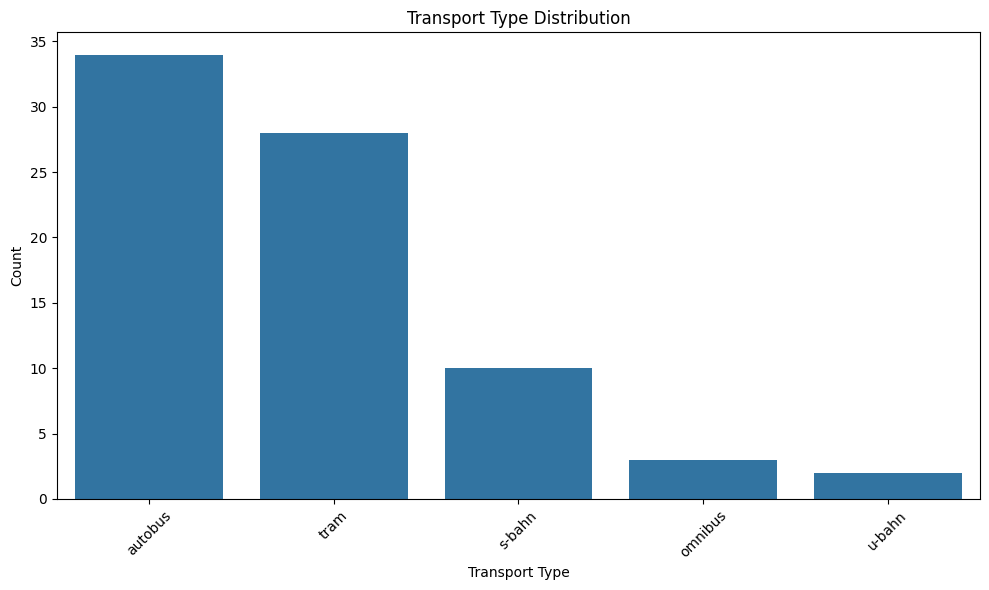

In [6]:
# Load the data again to analyze in more detail
data = verification.load_processed_data(BASE_DIR, YEAR, SIDE)
lines_df = data['lines']

# Display valid transport types
print(f"Valid transport types: {verification.VALID_TRANSPORT_TYPES}")
print()

# Analyze transport types
transport_counts = lines_df['type'].value_counts()
print("Transport types found in the data:")
for transport_type, count in transport_counts.items():
    print(f"- {transport_type}: {count} lines")

# Visualize transport type distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=transport_counts.index, y=transport_counts.values)
plt.title("Transport Type Distribution")
plt.xlabel("Transport Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2. Stop Connections Analysis

Analyze the number of connections per stop.

Connection counts:
- 1 connection: 692 stops
- 2 connections: 8 stops
- 3+ connections: 0 stops
- Disconnected stops: 0 stops


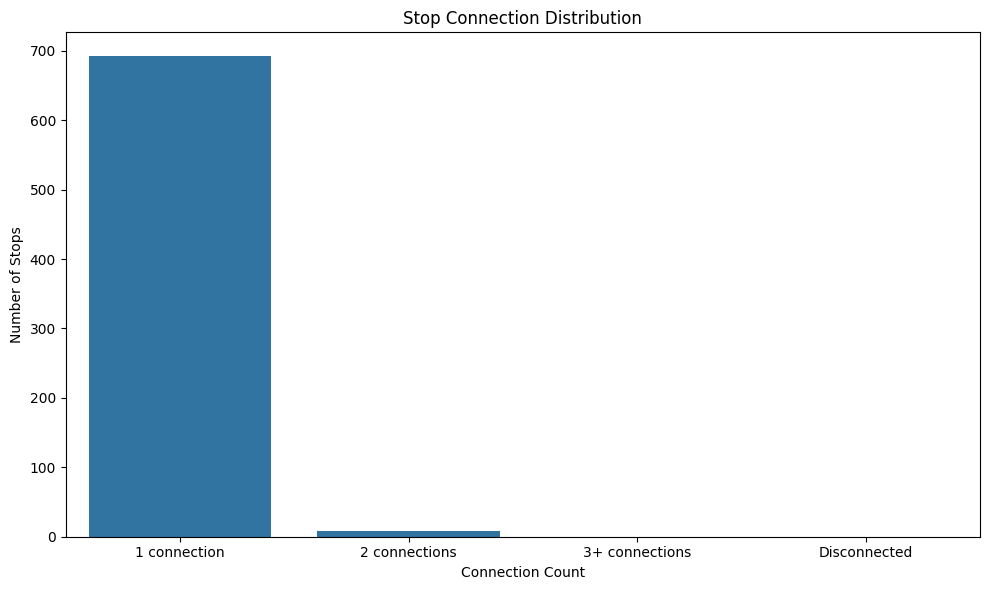

In [7]:
# Load data
stops_df = data['stops']
line_stops_df = data['line_stops']

# Count connections per stop
connection_counts = line_stops_df['stop_id'].value_counts().reset_index()
connection_counts.columns = ['stop_id', 'connection_count']

# Get counts by connection number
one_connection = len(connection_counts[connection_counts['connection_count'] == 1])
two_connections = len(connection_counts[connection_counts['connection_count'] == 2])
more_connections = len(connection_counts[connection_counts['connection_count'] > 2])

# Count disconnected stops
all_stop_ids = set(stops_df['stop_id'])
connected_stop_ids = set(line_stops_df['stop_id'])
disconnected_count = len(all_stop_ids - connected_stop_ids)

print("Connection counts:")
print(f"- 1 connection: {one_connection} stops")
print(f"- 2 connections: {two_connections} stops")
print(f"- 3+ connections: {more_connections} stops")
print(f"- Disconnected stops: {disconnected_count} stops")

# Visualize connection distribution
connection_distribution = pd.Series({
    "1 connection": one_connection,
    "2 connections": two_connections,
    "3+ connections": more_connections,
    "Disconnected": disconnected_count
})

plt.figure(figsize=(10, 6))
sns.barplot(x=connection_distribution.index, y=connection_distribution.values)
plt.title("Stop Connection Distribution")
plt.xlabel("Connection Count")
plt.ylabel("Number of Stops")
plt.tight_layout()
plt.show()

### 3. Examine Issues (if any)

If verification failed, examine the specific issues in more detail.

In [8]:
# Check for duplicate stops
if not results['stop_uniqueness']['valid']:
    print("DUPLICATE STOPS:")
    display(results['stop_uniqueness']['duplicates'].head(10))
    print(f"Showing 10 of {len(results['stop_uniqueness']['duplicates'])} duplicate stops")
    print()

# Check for disconnected stops
if results['stop_connections']['disconnected_count'] > 0:
    print("DISCONNECTED STOPS:")
    display(results['stop_connections']['disconnected'].head(10))
    print(f"Showing 10 of {len(results['stop_connections']['disconnected'])} disconnected stops")
    print()

# Check for stops with too many connections
if results['stop_connections']['too_many_connections_count'] > 0:
    print("STOPS WITH TOO MANY CONNECTIONS:")
    display(results['stop_connections']['too_many_connections'].head(10))
    print(f"Showing 10 of {len(results['stop_connections']['too_many_connections'])} stops with too many connections")
    print()

# Check for invalid line references
if results['referential_integrity']['invalid_line_refs_count'] > 0:
    print("INVALID LINE REFERENCES:")
    display(results['referential_integrity']['invalid_line_refs'].head(10))
    print(f"Showing 10 of {len(results['referential_integrity']['invalid_line_refs'])} invalid line references")
    print()

# Check for invalid stop references
if results['referential_integrity']['invalid_stop_refs_count'] > 0:
    print("INVALID STOP REFERENCES:")
    display(results['referential_integrity']['invalid_stop_refs'].head(10))
    print(f"Showing 10 of {len(results['referential_integrity']['invalid_stop_refs'])} invalid stop references")
    print()

# Check for missing geographic data
if results['geographic_data']['missing_geo_count'] > 0:
    print("STOPS WITH MISSING GEOGRAPHIC DATA:")
    display(results['geographic_data']['missing_geo'].head(10))
    print(f"Showing 10 of {len(results['geographic_data']['missing_geo'])} stops with missing geographic data")
    print()
    
# If all checks passed
if results['overall']:
    print("✅ All verification checks passed! The data is valid and ready for analysis.")

Distance Statistics:
- Total connections with valid distances: 631
- Average distance between stations: 1314.9 meters
- Minimum distance: 0.0 meters
- Maximum distance: 10728.9 meters

Average distances by transport type:
- autobus:
  • Average distance: 1330.3 meters
  • Standard deviation: 1053.1 meters
  • Range: 0.0 - 7801.9 meters
  • Number of connections: 183.0

- omnibus:
  • Average distance: 1433.3 meters
  • Standard deviation: 1218.1 meters
  • Range: 262.2 - 5113.1 meters
  • Number of connections: 29.0

- s-bahn:
  • Average distance: 1835.9 meters
  • Standard deviation: 1245.7 meters
  • Range: 671.7 - 10728.9 meters
  • Number of connections: 120.0

- tram:
  • Average distance: 1112.2 meters
  • Standard deviation: 627.4 meters
  • Range: 0.0 - 4282.5 meters
  • Number of connections: 279.0

- u-bahn:
  • Average distance: 705.5 meters
  • Standard deviation: 270.1 meters
  • Range: 0.0 - 1212.2 meters
  • Number of connections: 20.0



C:\Users\baumanoa\AppData\Local\Temp\ipykernel_1996\3872523266.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_distances['transport_type'] = valid_distances['stop_id'].map(stops_type_dict)


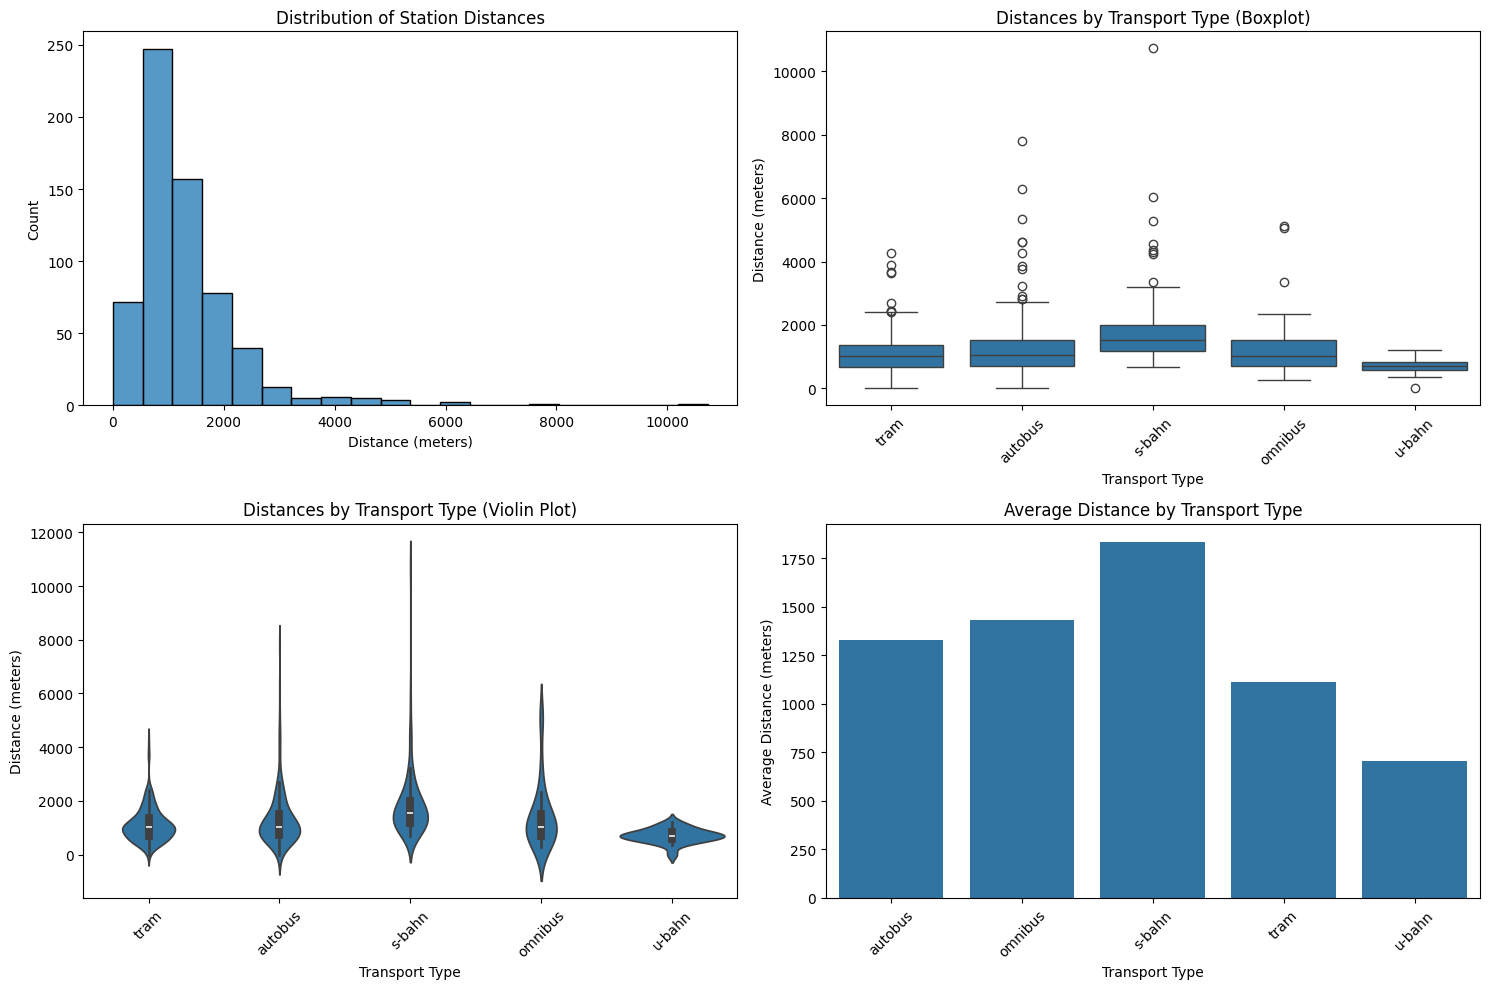


Problematic Connections:

Stations that are too close (<200m):


,stop_id,stop_name,line_id,distance_meters,transport_type
6,19646_east,Oranienburger Tor,19641_east,174.047308,tram
91,196491_east,"Hohenschönhausen, Gartenstadt",196411_east,62.234457,tram
136,1964136_east,Alt-Friedrichsfelde Ecke Am Tierpark,196414_east,0.000000,tram
387,1964384_east,Ridbacherstr.,196443_east,4.167182,tram
428,1964424_east,S-Bhf. Pankow,196448_east,0.000000,tram
469,1964465_east,Friedrichstr.,196454_east,0.000000,tram
489,1964485_east,Neu-Lindenberg,196458_east,0.000000,tram
670,1964666_east,"Rüdersdorf, Post",196473_east,48.191495,tram
696,1964688_east,Stadtmitte,196476_east,0.000000,tram



Stations that are too far apart:


,stop_id,stop_name,line_id,distance_meters,transport_type,max_allowed_distance
0,19640_east,Ostbahnhof,19641_east,1011.260880,tram,1000
2,19642_east,Leninplatz,19641_east,1456.684228,tram,1000
4,19644_east,Rosenthalerplatz,19641_east,1275.293861,tram,1000
14,196414_east,Bhf. Frankfurterallee,19643_east,1424.983766,tram,1000
15,196415_east,Roederplatz,19643_east,1115.354469,tram,1000
18,196418_east,Klement-Gottwald-Allee,19643_east,1018.833732,tram,1000
19,196419_east,Antonplatz,19643_east,1485.441782,tram,1000
20,196420_east,Prenzlauer Promenade,19643_east,1135.999045,tram,1000
34,196434_east,S-Bhf. Jannowitzbrücke,19645_east,1060.452849,tram,1000
37,196437_east,Brunnenstr. Ecke Invalidenstr.,19645_east,1023.727893,tram,1000


(Showing 10 of 364 connections that are too far)


In [9]:
# Cell 19 (Markdown):
"""
### 4. Station Distance Analysis

Analyze the distances between connected stations to identify potential geolocation issues.
"""

# Cell 20 (Code):
# Check if we have the enriched data with distances
if 'station_distances' in results:
    # Get distance check results
    too_close = results['station_distances'].get('too_close', pd.DataFrame())
    too_far = results['station_distances'].get('too_far', pd.DataFrame())
    
    # Load the line_stops with distances
    line_stops_with_dist = pd.read_csv(BASE_DIR / 'processed' / f"{YEAR}_{SIDE}" / "line_stops_with_dist.csv")
    
    # Summary statistics
    valid_distances = line_stops_with_dist[line_stops_with_dist['distance_meters'].notna()]
    
    if not valid_distances.empty:
        print("Distance Statistics:")
        print(f"- Total connections with valid distances: {len(valid_distances)}")
        print(f"- Average distance between stations: {valid_distances['distance_meters'].mean():.1f} meters")
        print(f"- Minimum distance: {valid_distances['distance_meters'].min():.1f} meters")
        print(f"- Maximum distance: {valid_distances['distance_meters'].max():.1f} meters")
        print()
        
        # Get transport type for each connection if not already included
        if 'transport_type' not in valid_distances.columns:
            # Load stops data to get transport types
            stops_df = pd.read_csv(BASE_DIR / 'processed' / f"{YEAR}_{SIDE}" / "stops.csv")
            
            # Join with line_stops to get transport type
            stops_type_dict = stops_df[['stop_id', 'type']].set_index('stop_id')['type'].to_dict()
            valid_distances['transport_type'] = valid_distances['stop_id'].map(stops_type_dict)
        
        # Group by transport type and calculate statistics
        print("Average distances by transport type:")
        transport_stats = valid_distances.groupby('transport_type')['distance_meters'].agg(
            ['count', 'mean', 'std', 'min', 'max']
        )
        
        # Format and display the results
        for transport_type, stats in transport_stats.iterrows():
            print(f"- {transport_type}:")
            print(f"  • Average distance: {stats['mean']:.1f} meters")
            print(f"  • Standard deviation: {stats['std']:.1f} meters")
            print(f"  • Range: {stats['min']:.1f} - {stats['max']:.1f} meters")
            print(f"  • Number of connections: {stats['count']}")
            print()
        
        # Visualize distance distribution
        plt.figure(figsize=(15, 10))
        
        # Plot histogram of distances
        plt.subplot(2, 2, 1)
        sns.histplot(valid_distances['distance_meters'], bins=20)
        plt.title("Distribution of Station Distances")
        plt.xlabel("Distance (meters)")
        plt.ylabel("Count")
        
        # Plot distances by transport type - boxplot
        plt.subplot(2, 2, 2)
        sns.boxplot(x='transport_type', y='distance_meters', data=valid_distances)
        plt.title("Distances by Transport Type (Boxplot)")
        plt.xlabel("Transport Type")
        plt.ylabel("Distance (meters)")
        plt.xticks(rotation=45)
        
        # Plot distances by transport type - violin plot
        plt.subplot(2, 2, 3)
        sns.violinplot(x='transport_type', y='distance_meters', data=valid_distances)
        plt.title("Distances by Transport Type (Violin Plot)")
        plt.xlabel("Transport Type")
        plt.ylabel("Distance (meters)")
        plt.xticks(rotation=45)
        
        # Plot average distances by transport type - bar plot
        plt.subplot(2, 2, 4)
        transport_means = valid_distances.groupby('transport_type')['distance_meters'].mean().reset_index()
        sns.barplot(x='transport_type', y='distance_meters', data=transport_means)
        plt.title("Average Distance by Transport Type")
        plt.xlabel("Transport Type")
        plt.ylabel("Average Distance (meters)")
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Show problematic connections
        if not too_close.empty or not too_far.empty:
            print("\nProblematic Connections:")
            
            if not too_close.empty:
                print("\nStations that are too close (<200m):")
                display(too_close[['stop_id', 'stop_name', 'line_id', 'distance_meters', 'transport_type']].head(10))
                if len(too_close) > 10:
                    print(f"(Showing 10 of {len(too_close)} connections that are too close)")
            
            if not too_far.empty:
                print("\nStations that are too far apart:")
                display(too_far[['stop_id', 'stop_name', 'line_id', 'distance_meters', 'transport_type', 'max_allowed_distance']].head(10))
                if len(too_far) > 10:
                    print(f"(Showing 10 of {len(too_far)} connections that are too far)")
    else:
        print("No valid distances between stations were calculated.")
else:
    print("Station distance verification results not available.")

In [10]:
too_far

,stop_order,stop_id,line_id,distance_meters,transport_type,max_allowed_distance,stop_name
0,0,19640_east,19641_east,1011.260880,tram,1000,Ostbahnhof
2,2,19642_east,19641_east,1456.684228,tram,1000,Leninplatz
4,4,19644_east,19641_east,1275.293861,tram,1000,Rosenthalerplatz
14,3,196414_east,19643_east,1424.983766,tram,1000,Bhf. Frankfurterallee
15,4,196415_east,19643_east,1115.354469,tram,1000,Roederplatz
...,...,...,...,...,...,...,...
683,1,1964482_east,196475_east,1116.714891,tram,1000,Eichbuschplatz
684,2,1964483_east,196475_east,1175.760625,tram,1000,Joachimstr.
686,0,1964678_east,196476_east,1092.283358,tram,1000,Pankow (Vinetastr.)
688,2,1964680_east,196476_east,1026.982445,tram,1000,Dimitroffstr.


In [11]:
too_close

,stop_order,stop_id,line_id,distance_meters,transport_type,max_allowed_distance,stop_name
6,6,19646_east,19641_east,174.047308,tram,1000,Oranienburger Tor
91,0,196491_east,196411_east,62.234457,tram,1000,"Hohenschönhausen, Gartenstadt"
136,6,1964136_east,196414_east,0.000000,tram,1000,Alt-Friedrichsfelde Ecke Am Tierpark
387,1,1964384_east,196443_east,4.167182,tram,1000,Ridbacherstr.
428,6,1964424_east,196448_east,0.000000,tram,1000,S-Bhf. Pankow
469,5,1964465_east,196454_east,0.000000,tram,1000,Friedrichstr.
489,0,1964485_east,196458_east,0.000000,tram,1000,Neu-Lindenberg
670,11,1964666_east,196473_east,48.191495,tram,1000,"Rüdersdorf, Post"
696,10,1964688_east,196476_east,0.000000,tram,1000,Stadtmitte
